In [5]:
import os

import torch
from torch import nn
from torch.optim import Adam
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

from data.dataloader import dataloader_info
from utils.utils import load_yaml_config, instantiate_from_config

from models.predictor import GRU
from models.solver import Trainer
from data.dataloader import dataloader_info
from utils.visualize import visualize_pca, visualize_tsne, visualize_kernel
from models.solver import train_prediction_model, evaluate_model

import copy

In [6]:
# Load configurations
configs = load_yaml_config("configs/stock_test.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize Diffusion_TS Model
diffusion_ts = instantiate_from_config(configs['gen_model']).to(device)
batch_size = 128

In [7]:
# dataloader
dl_info = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dl_info_test["dataloader"]
dl_info_test["dataset"]

dataset = dl_info['dataset']

In [6]:
# train
trainer = Trainer(config_solver=configs["gen_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
trainer.train_decomp()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
combiend_loss: 0.289705 l1_loss : 0.334407 fourier_loss : 0.086318 adv_loss : 0.000000: 100%|██████████| 5000/5000 [04:36<00:00, 18.09it/s]


In [7]:
# generate adversarial data
fake_data = diffusion_ts.generate_mts(batch_size=3000)

reverse step from x_T to x_0: 100%|██████████| 500/500 [02:24<00:00,  3.46it/s]


In [8]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
gt_data = np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))
idx = np.random.permutation(len(gt_data))[:3000]
ori_data = gt_data[idx]

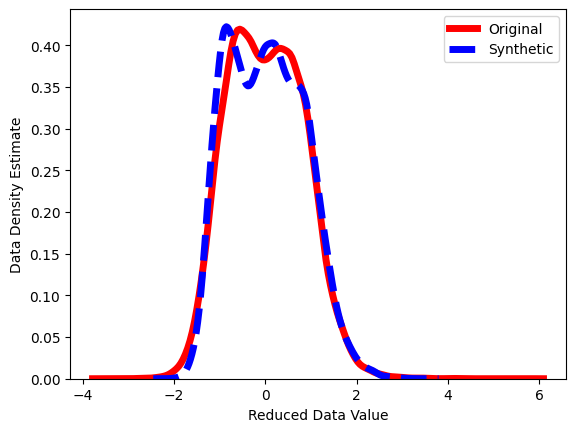

In [9]:
visualize_kernel(ori_data, fake_data, 3000)

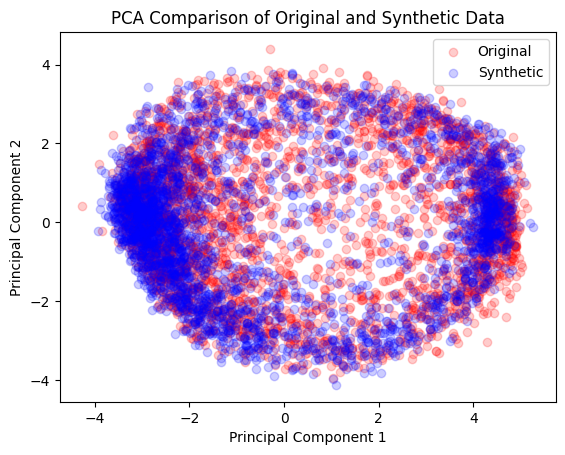

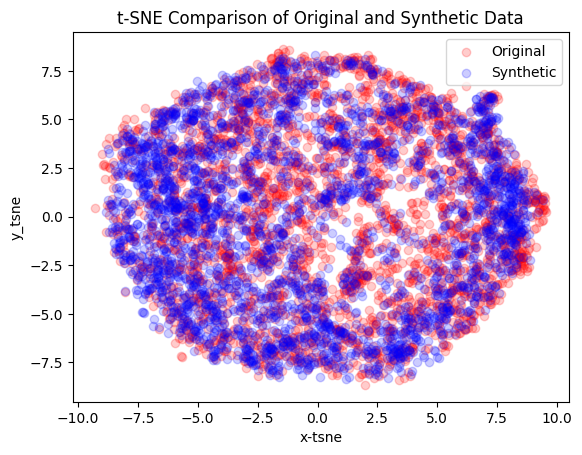

In [10]:
visualize_pca(ori_data, fake_data, 3000)
visualize_tsne(ori_data, fake_data, 3000)

In [9]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lossfn = nn.L1Loss()
# lossfn = nn.MSELoss()


In [12]:
gt_predictor = GRU(6, 50, 1, 2).to(device)
gt_optimizer = Adam(gt_predictor.parameters(), lr=0.001)
# save_path = "output/gt_predictor_2000.pth"
save_path = "output/predictor_2000.pth"

# try :
#     gt_predictor.load_state_dict(torch.load("output/gt_predictor_2000.pth"))
# except:
#     train_prediction_model(gt_predictor, dl_info["dataloader"],gt_criterion, gt_optimizer, device=device, epochs=2000, save_path=save_path)
train_prediction_model(gt_predictor, dl_info["dataloader"],lossfn, gt_optimizer, device=device, epochs=2000, save_path=save_path)


 loss: 0.018626: 100%|██████████| 2000/2000 [00:48<00:00, 41.17it/s]


In [13]:
predictor = copy.deepcopy(gt_predictor)
optimizer = Adam(predictor.parameters(), lr=0.001)



In [14]:
adv_l1, adv_l2, mape_adv, pred_y_adv, true_y = evaluate_model(predictor, dl_info["dataloader"], device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f}%")

adv_l1, adv_l2, mape_adv, pred_y_adv_test, true_y_test = evaluate_model(predictor, test_loader, device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f} %")


Adv Model : 	 L1 loss: 0.01806 	 L2 Loss : 0.00111 	 MAPE loss : 0.05084%
Adv Model : 	 L1 loss: 0.35235 	 L2 Loss : 0.28990 	 MAPE loss : 1.21999 %


/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:1133: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


In [ ]:
diffusion_ts.set_predictor(predictor)

In [ ]:
try:
    diffusion_ts.load_state_dict(torch.load("check_points/stock/gen_24/model_5000.pth"))
except:
    trainer = Trainer(config_solver=configs["gen_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
    trainer.train_decomp()


In [ ]:
trainer = Trainer(config_solver=configs["adv_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
trainer.train_decomp()

  0%|          | 0/1000 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
combiend_loss: -0.071530 l1_loss : 1.229037 fourier_loss : 0.050175 adv_loss : 1.240919: 100%|██████████| 1000/1000 [01:00<00:00, 16.48it/s]


In [15]:


adv_l1, adv_l2, mape_adv, pred_y_adv, true_y = evaluate_model(predictor, dl_info["dataloader"], device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f}%")

adv_l1, adv_l2, mape_adv, pred_y_adv_test, true_y_test = evaluate_model(predictor, test_loader, device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f} %")


AttributeError: 'Diffusion_TS' object has no attribute 'predictor'

In [ ]:
# generate adversarial data
adv_data = diffusion_ts.generate_mts(batch_size=1000)

reverse step from x_T to x_0:   0%|          | 0/500 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
reverse step from x_T to x_0: 100%|██████████| 500/500 [00:49<00:00, 10.05it/s]


In [ ]:
ori_adv_data = np.concatenate([dataset.data, adv_data])
ori_adv_data = torch.from_numpy(ori_adv_data).to(device)
ori_adv_dl = DataLoader(ori_adv_data, batch_size=batch_size)

In [ ]:
save_path = "output/predictor_2000.pth"
train_prediction_model(predictor, 
                        ori_adv_dl, 
                        lossfn, 
                        optimizer, 
                        device=device, 
                        epochs=2000, 
                        description="adversarial", 
                        save_path=save_path)
adv_l1, adv_l2, mape_adv, pred_y_adv_test, true_y_test = evaluate_model(predictor, test_loader, device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f} %")


  0%|          | 0/1000 [00:00<?, ?it/s]

adversarial loss: 0.003154: 100%|██████████| 1000/1000 [00:30<00:00, 32.66it/s]


Adv Model : 	 L1 loss: 0.65371 	 L2 Loss : 0.80965 	 MAPE loss : 2.16129 %


In [ ]:
for _ in range(100):
    trainer = Trainer(config_solver=configs["adv_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
    trainer.train_decomp()
    # generate adversarial data
    adv_data = diffusion_ts.generate_mts(batch_size=1000)
    ori_adv_data = np.concatenate([dataset.data, adv_data])
    ori_adv_data = torch.from_numpy(ori_adv_data).to(device)
    ori_adv_dl = DataLoader(ori_adv_data, batch_size=batch_size)
    train_prediction_model(predictor, 
                            ori_adv_dl, 
                            lossfn, 
                            optimizer, 
                            device=device, 
                            epochs=2000, 
                            description="adversarial", 
                            save_path=save_path)
    
    adv_l1, adv_l2, mape_adv, pred_y_adv_test, true_y_test = evaluate_model(predictor, test_loader, device)
    print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f} %")

combiend_loss: -0.037898 l1_loss : 1.018425 fourier_loss : 0.041577 adv_loss : 0.952599: 100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]
adversarial loss: 0.004355: 100%|██████████| 1000/1000 [00:31<00:00, 32.09it/s]


Adv Model : 	 L1 loss: 0.67762 	 L2 Loss : 0.87017 	 MAPE loss : 2.25942 %


combiend_loss: 0.132072 l1_loss : 0.883846 fourier_loss : 0.036083 adv_loss : 0.638079: 100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s]
adversarial loss: 0.000492: 100%|██████████| 1000/1000 [00:31<00:00, 32.13it/s]


Adv Model : 	 L1 loss: 0.72749 	 L2 Loss : 1.00673 	 MAPE loss : 2.09391 %


combiend_loss: 0.192401 l1_loss : 0.419284 fourier_loss : 0.017117 adv_loss : 0.149642: 100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]
adversarial loss: 0.001820: 100%|██████████| 1000/1000 [00:31<00:00, 32.17it/s]


Adv Model : 	 L1 loss: 0.86077 	 L2 Loss : 1.44272 	 MAPE loss : 2.20620 %


combiend_loss: 0.022460 l1_loss : 1.716629 fourier_loss : 0.070081 adv_loss : 1.665969: 100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s]
reverse step from x_T to x_0:  11%|█         | 56/500 [00:05<00:44, 10.01it/s]

In [ ]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
gt_data = np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))
idx = np.random.permutation(len(gt_data))[:3000]
ori_data = gt_data[idx]

In [ ]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# lossfn = nn.L1Loss()
lossfn = nn.MSELoss()


In [ ]:
gt_predictor = GRU(5, 50, 1, 2).to(device)
gt_optimizer = Adam(gt_predictor.parameters(), lr=0.001)
# save_path = "output/gt_predictor_2000.pth"
save_path = "output/predictor_2000.pth"

# try :
#     gt_predictor.load_state_dict(torch.load("output/gt_predictor_2000.pth"))
# except:
#     train_prediction_model(gt_predictor, dl_info["dataloader"],gt_criterion, gt_optimizer, device=device, epochs=2000, save_path=save_path)
train_prediction_model(gt_predictor, dl_info["dataloader"],lossfn, gt_optimizer, device=device, epochs=2000, save_path=save_path)


 loss: 0.000531: 100%|██████████| 2000/2000 [00:46<00:00, 43.17it/s]


In [ ]:
predictor = copy.deepcopy(gt_predictor)
optimizer = Adam(predictor.parameters(), lr=0.001)


In [ ]:
adv_l1, adv_l2, mape_adv, pred_y_adv, true_y = evaluate_model(predictor, dl_info["dataloader"], device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f}%")

adv_l1, adv_l2, mape_adv, pred_y_adv_test, true_y_test = evaluate_model(predictor, test_loader, device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f} %")


/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:1133: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


Adv Model : 	 L1 loss: 0.02120 	 L2 Loss : 0.00077 	 MAPE loss : 0.71828%
Adv Model : 	 L1 loss: 0.65954 	 L2 Loss : 0.81424 	 MAPE loss : 2.06322 %


In [ ]:
diffusion_ts.set_predictor(predictor)

In [ ]:
try:
    diffusion_ts.load_state_dict(torch.load("check_points/stock/gen_24/model_5000.pth"))
except:
    trainer = Trainer(config_solver=configs["gen_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
    trainer.train_decomp()


In [ ]:
trainer = Trainer(config_solver=configs["adv_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
trainer.train_decomp()

  0%|          | 0/1000 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
combiend_loss: -0.071530 l1_loss : 1.229037 fourier_loss : 0.050175 adv_loss : 1.240919: 100%|██████████| 1000/1000 [01:00<00:00, 16.48it/s]


In [ ]:
adv_l1, adv_l2, mape_adv, pred_y_adv, true_y = evaluate_model(diffusion_ts.predictor, dl_info["dataloader"], device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f}%")


adv_l1, adv_l2, mape_adv, pred_y_adv, true_y = evaluate_model(predictor, dl_info["dataloader"], device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f}%")

Adv Model : 	 L1 loss: 0.02118 	 L2 Loss : 0.00076 	 MAPE loss : 0.71863%
Adv Model : 	 L1 loss: 0.02118 	 L2 Loss : 0.00076 	 MAPE loss : 0.71919%


In [ ]:
# generate adversarial data
adv_data = diffusion_ts.generate_mts(batch_size=1000)

reverse step from x_T to x_0:   0%|          | 0/500 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
reverse step from x_T to x_0: 100%|██████████| 500/500 [00:49<00:00, 10.05it/s]


In [ ]:
ori_adv_data = np.concatenate([dataset.data, adv_data])
ori_adv_data = torch.from_numpy(ori_adv_data).to(device)
ori_adv_dl = DataLoader(ori_adv_data, batch_size=batch_size)

In [ ]:
save_path = "output/predictor_2000.pth"
train_prediction_model(predictor, 
                        ori_adv_dl, 
                        lossfn, 
                        optimizer, 
                        device=device, 
                        epochs=2000, 
                        description="adversarial", 
                        save_path=save_path)
adv_l1, adv_l2, mape_adv, pred_y_adv_test, true_y_test = evaluate_model(predictor, test_loader, device)
print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f} %")


  0%|          | 0/1000 [00:00<?, ?it/s]

adversarial loss: 0.003154: 100%|██████████| 1000/1000 [00:30<00:00, 32.66it/s]


Adv Model : 	 L1 loss: 0.65371 	 L2 Loss : 0.80965 	 MAPE loss : 2.16129 %


In [ ]:
for _ in range(100):
    trainer = Trainer(config_solver=configs["adv_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
    trainer.train_decomp()
    # generate adversarial data
    adv_data = diffusion_ts.generate_mts(batch_size=1000)
    ori_adv_data = np.concatenate([dataset.data, adv_data])
    ori_adv_data = torch.from_numpy(ori_adv_data).to(device)
    ori_adv_dl = DataLoader(ori_adv_data, batch_size=batch_size)
    train_prediction_model(predictor, 
                            ori_adv_dl, 
                            lossfn, 
                            optimizer, 
                            device=device, 
                            epochs=2000, 
                            description="adversarial", 
                            save_path=save_path)
    
    adv_l1, adv_l2, mape_adv, pred_y_adv_test, true_y_test = evaluate_model(predictor, test_loader, device)
    print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f} %")

combiend_loss: -0.037898 l1_loss : 1.018425 fourier_loss : 0.041577 adv_loss : 0.952599: 100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]
adversarial loss: 0.004355: 100%|██████████| 1000/1000 [00:31<00:00, 32.09it/s]


Adv Model : 	 L1 loss: 0.67762 	 L2 Loss : 0.87017 	 MAPE loss : 2.25942 %


combiend_loss: 0.132072 l1_loss : 0.883846 fourier_loss : 0.036083 adv_loss : 0.638079: 100%|██████████| 1000/1000 [01:00<00:00, 16.54it/s]
adversarial loss: 0.000492: 100%|██████████| 1000/1000 [00:31<00:00, 32.13it/s]


Adv Model : 	 L1 loss: 0.72749 	 L2 Loss : 1.00673 	 MAPE loss : 2.09391 %


combiend_loss: 0.192401 l1_loss : 0.419284 fourier_loss : 0.017117 adv_loss : 0.149642: 100%|██████████| 1000/1000 [00:56<00:00, 17.74it/s]
adversarial loss: 0.001820: 100%|██████████| 1000/1000 [00:31<00:00, 32.17it/s]


Adv Model : 	 L1 loss: 0.86077 	 L2 Loss : 1.44272 	 MAPE loss : 2.20620 %


combiend_loss: 0.022460 l1_loss : 1.716629 fourier_loss : 0.070081 adv_loss : 1.665969: 100%|██████████| 1000/1000 [01:01<00:00, 16.27it/s]
reverse step from x_T to x_0:  11%|█         | 56/500 [00:05<00:44, 10.01it/s]